In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV, train_test_split
from sklearn.metrics import classification_report
import numpy as np
from SVM_pipeline import SVM_Pipeline 

In [2]:
random_state = 42
# Generate random data
np.random.seed(random_state)
n_samples = 120
n_features = 2

feature_columns = [f'feature_{i}' for i in range(n_features)]
# Generate six clusters centered at different locations
centers = [(-4, -4), (-2, 2), (0, 0), (2, -2), (4, 4), (2, 2)]
samples_per_class = n_samples // 6

X_list = []
activities = []
for i, center in enumerate(centers):
    X_class = np.random.randn(samples_per_class, n_features) + np.array(center)
    X_list.append(X_class)
    activities.extend([i] * samples_per_class)

X_random = np.vstack(X_list)
activities = np.array(activities)

# Assign subject_ids randomly
subject_ids = np.random.randint(0, 6, size=n_samples)
df = pd.DataFrame(X_random, columns=feature_columns)
df['subject_id'] = subject_ids
df['activity'] = activities

In [3]:
# 1. Load data
# df = pd.read_csv('your_data.csv')
X = df[feature_columns]
y = df['activity']
groups = df['subject_id']

Set up SVM pipeline by choosing hyperparameter grid and scaler. The hyperparameter selection uses leave-one-group-out strategy to decide on hyperparameters.


In [7]:
svm_pipeline = SVM_Pipeline()
# Define the parameter grid for GridSearchCV
param_grid = {
    'scaler' : [StandardScaler(), MinMaxScaler(), None],
    'sfs__k_features': [n_features],  # Select from 1 to all features
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}
svm_pipeline.set_param_grid(param_grid)

Initialize and split the dataset.


In [8]:
X_train, X_test, y_train, y_test, groups_train, groups_test \
= svm_pipeline.init_and_split_data(df, split_ratio=0.2, random_state=random_state)

Conduct the gridsearch to find the best model.

In [9]:
svm_pipeline.run_grid_search(X_train, y_train, groups_train)
svm_pipeline.show_grid_search_results()

c:\Users\Aybar\anaconda3\envs\python-12\Lib\site-packages\sklearn\model_selection\_split.py:86: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


                                               params  mean_test_score  \
0   {'scaler': StandardScaler(), 'sfs__k_features'...         0.751053   
1   {'scaler': StandardScaler(), 'sfs__k_features'...         0.531053   
2   {'scaler': StandardScaler(), 'sfs__k_features'...         0.751053   
3   {'scaler': StandardScaler(), 'sfs__k_features'...         0.531053   
4   {'scaler': StandardScaler(), 'sfs__k_features'...         0.866316   
5   {'scaler': StandardScaler(), 'sfs__k_features'...         0.845263   
6   {'scaler': StandardScaler(), 'sfs__k_features'...         0.866316   
7   {'scaler': StandardScaler(), 'sfs__k_features'...         0.845263   
8   {'scaler': StandardScaler(), 'sfs__k_features'...         0.845263   
9   {'scaler': StandardScaler(), 'sfs__k_features'...         0.865789   
10  {'scaler': StandardScaler(), 'sfs__k_features'...         0.845263   
11  {'scaler': StandardScaler(), 'sfs__k_features'...         0.865789   
12  {'scaler': MinMaxScaler(), 'sfs__k

,params,mean_test_score,std_test_score,rank_test_score
0,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.751053,0.086026,24
1,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.531053,0.088578,30
2,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.751053,0.086026,24
3,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.531053,0.088578,30
4,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.866316,0.091863,3
5,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.845263,0.094947,11
6,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.866316,0.091863,3
7,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.845263,0.094947,11
8,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.845263,0.082455,11
9,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.865789,0.074618,7


Best params: {'scaler': None, 'sfs__k_features': 2, 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}


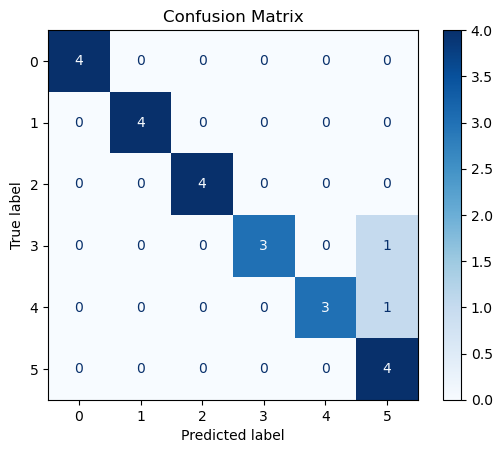

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4.0},
 '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4.0},
 '3': {'precision': 1.0,
  'recall': 0.75,
  'f1-score': 0.8571428571428571,
  'support': 4.0},
 '4': {'precision': 1.0,
  'recall': 0.75,
  'f1-score': 0.8571428571428571,
  'support': 4.0},
 '5': {'precision': 0.6666666666666666,
  'recall': 1.0,
  'f1-score': 0.8,
  'support': 4.0},
 'accuracy': 0.9166666666666666,
 'macro avg': {'precision': 0.9444444444444445,
  'recall': 0.9166666666666666,
  'f1-score': 0.919047619047619,
  'support': 24.0},
 'weighted avg': {'precision': 0.9444444444444445,
  'recall': 0.9166666666666666,
  'f1-score': 0.919047619047619,
  'support': 24.0}}

In [10]:
# Evaluate the best model on the test set
svm_pipeline.evaluate_model(X_test, y_test)

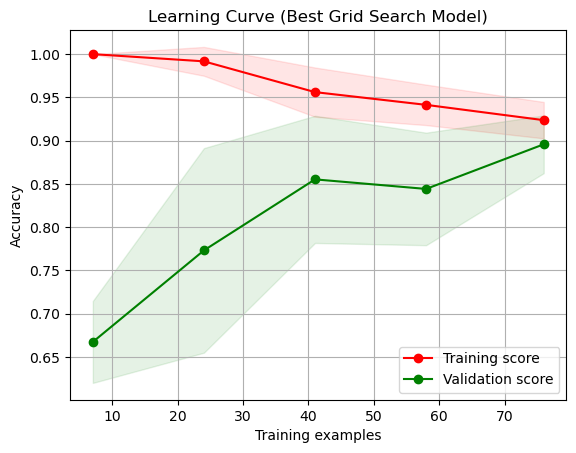

In [11]:
# Plot learning curve to check overfitting
svm_pipeline.plot_learning_curve(X_train, y_train)

c:\Users\Aybar\anaconda3\envs\python-12\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


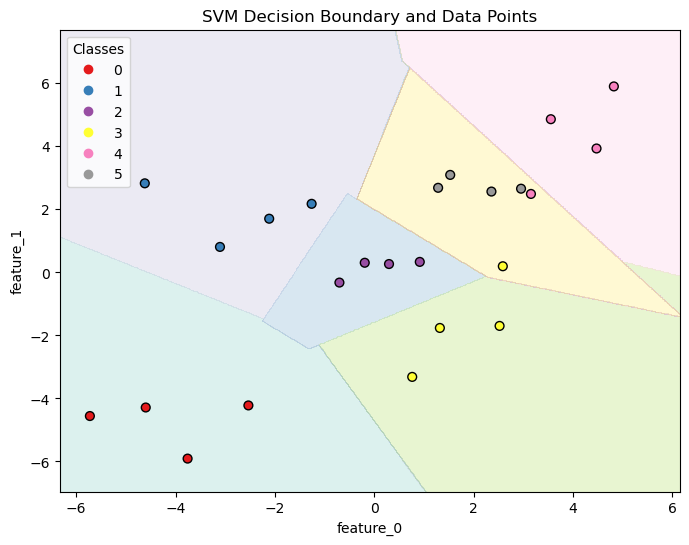

In [11]:
import matplotlib.pyplot as plt

# Get best estimator from grid search
best_svm = svm_pipeline.grid_search.best_estimator_

# Create a mesh to plot decision boundary
h = .02  # step size in the mesh
x_min, x_max = X_train['feature_0'].min() - 1, X_train['feature_0'].max() + 1
y_min, y_max = X_train['feature_1'].min() - 1, X_train['feature_1'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict on mesh
Z = best_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set3)

# Plot the training points
scatter = plt.scatter(X_test['feature_0'], X_test['feature_1'], c=y_test, cmap=plt.cm.Set1, edgecolor='k', s=40)
plt.xlabel('feature_0')
plt.ylabel('feature_1')
plt.title('SVM Decision Boundary and Data Points')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()